# Drift Detection in Episodic Data

This project presents the code used for the paper [Drift Detection in Episodic Data: Detect When Your Agent Starts Faltering](https://arxiv.org/abs/2010.11660).

This notebook contains:
1. A description of the required input structure of the rewards dataset.
2. A demonstration of the analysis for a small dataset (available in the repo).
3. The analysis of the full rewards data used for the paper (several hundreds MB; available upon request).

In [3]:
# Auto reload
%reload_ext autoreload
%autoreload 2

# Basic IO
import os, sys
import pickle as pkl
import gc
from pprint import pprint
from warnings import warn
from pathlib import Path
from time import time, sleep
from datetime import datetime
from tqdm import tqdm, tnrange, tqdm_notebook

# Basic science
import numpy as np
import scipy as sp
import scipy.stats as stats
import scipy.linalg as la
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams.update({'font.size': 14})

# Learning
import torch

import utils
import BasicAnalyzer as Analyzer
import StatsCalculator as Stats

Make wide notebook:

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))

np.set_printoptions(precision=3)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)

%matplotlib inline

from time import time, sleep
sleep(0.1)

# Rewards input dataset - a guided example

In [27]:
# load data
with open('data/HalfCheetah_data.pkl','rb') as fd:
    saved_data = pkl.load(fd)
scenarios_summary = saved_data['scenarios']
env_args = saved_data['env_args']
data = saved_data['data']

# env_args
print('Scenarios configuration arguments:')
print('\tThis variable (env_args) is stored for reproducibility and is not used directly by the Analyzer class.')
print('\tenv_args[scenario_name] = dict of arguments used to generate the scenario rewards data.')
print(f'\tTotal number of scenarios: {len(env_args)}')
print('\tA sample of scenarios:', list(env_args.keys())[:3], list(env_args.keys())[-3:])
print(f'\tNumber of unique scenarios: {len(np.unique([sc[:-3] if sc!="ref" else sc for sc in env_args.keys()]))}')
print('\t', np.unique([sc[:-3] if sc!="ref" else sc for sc in env_args]))
print('Note that each scenario here corresponds to a block of episodes in the terminology of the paper.')
print('\tExample - ccost110_00 args:', env_args['ccost110_00'])

# data
print('Rewards data:')
print('\tdata[scenario_name] = list of lists R, where R[i][t] = reward in episode i and time t.')
print(f'\tTotal number of scenarios: {len(data)}')
print('\tData shape for the reference scenario:', np.array(data['ref']).shape)
print('\tData shape for an arbitrary scenario:', np.array(data['H0_00']).shape)

print('Scenarios summary:')
print('\tA dataframe as shown below. Each row corresponds to a single episode in a certain scenario.')
scenarios_summary

Scenarios configuration arguments:
	This variable (env_args) is stored for reproducibility and is not used directly by the Analyzer class.
	env_args[scenario_name] = dict of arguments used to generate the scenario rewards data.
	Total number of scenarios: 701
	A sample of scenarios: ['ref', 'H0_00', 'H0_01'] ['gravity120_97', 'gravity120_98', 'gravity120_99']
	Number of unique scenarios: 8
	 ['H0' 'ccost110' 'ccost130' 'gravity09' 'gravity120' 'mass090' 'mass_120' 'ref']
Note that each scenario here corresponds to a block of episodes in the terminology of the paper.
	Example - ccost110_00 args: {'ctrl_cost': 0.11}
Rewards data:
	data[scenario_name] = list of lists R, where R[i][t] = reward in episode i and time t.
	Total number of scenarios: 701
	Data shape for the reference scenario: (10000, 1000)
	Data shape for an arbitrary scenario: (50, 1000)
Scenarios summary:
	A dataframe as shown below. Each row corresponds to a single episode in a certain scenario.


episode  episode_in_scenario       scenario   seed     score
0            0                    0            ref   1821  0.086591
1            1                    1            ref  33356  6.762040
2            2                    2            ref  40712  6.094947
3            3                    3            ref  13358  6.480465
4            4                    4            ref  36178  6.904617
...        ...                  ...            ...    ...       ...
44995    44995                   45  gravity120_99   2294  5.801377
44996    44996                   46  gravity120_99  14736  5.814665
44997    44997                   47  gravity120_99  19597  5.813720
44998    44998                   48  gravity120_99  27687  5.878772
44999    44999                   49  gravity120_99  10144  5.678652

[45000 rows x 5 columns]

# Analysis demonstration

Analysis demonstration on a small sample dataset available in the repo.

Define tests configurations (similarly to the experiments in the paper):

In [67]:
tests = dict(
        Mean = (Stats.SimpleMean, dict()),
        CUSUM = (Stats.CUSUM, dict()),
        Hot = (Stats.Hotelling, dict()),
        UDT = (Stats.WeightedMean, dict()),
        PDT = (Stats.TransformedCVaR, dict(p=0.9)),
        MDT = (Stats.MixTest, dict(tests_confs=((Stats.SimpleMean, dict(title='Mean')),
                                                (Stats.TransformedCVaR, dict(title='PDM',p=0.9)),
                                                (Stats.Hotelling, dict(title='Hot'))),
                                   Bfac=2)), # factor between bootstrap resolution of the mixed test and of its inner tests
)

**Individual tests** alone are quite fast (see below - less than 1 minute wall-time for the sample data).
Note that the first scenario is always slower because that's where the bootstrap is done.

The figures show some descriptive information about the various scenarios (6 rows of figures in this example); the weights of the tests determined by the reference data (1 row); the results per scenario (2 rows); and the results per amount of data (2 rows).

It is evident that **for H0 most rejection rates are around $\alpha=0.05$ as required** (note that the sample dataset includes only 20 blocks of episodes per scenario, so the accuracy cannot be great here).

For the alternative scenario (increased control cost), it is clear that **our tests (\*DT) are more powerful than the alternative tests (Mean, CUSUM, Hotelling)** - for any amount of data.

Note that $t=10^3$ corresponds to a single episode. In particular, the rejection rate of the alternative tests (Mean, CUSUM, Hotelling) gets *worse* after the noisy parts of the first episode, as discussed in the paper.

In [69]:
# load saved data 
A = Analyzer.Analyzer('HalfCheetah_sample_data', Path('.'), resolution=25, title='HalfCheetah_demo') # resolution=25 -> split time to intervals of size 25 and take the average of each interval
A.get_meta_scenarios_summary();

meta_scenario
H0          1000 episodes, 20 blocks, 1000 unique seeds.
ccost130    1000 episodes, 20 blocks, 1000 unique seeds.
ref          2000 episodes, 1 blocks, 2000 unique seeds.
dtype: object


In [74]:
%%time
# run individual tests
# (levels=1 for individual, 3 for individual+sequential)
null = A.run_summarizing_tests(save_name='HalfCheetah_demo_individual', ns=(100,300,1000,3000,10000), default_tester_args=dict(B=5000), tests=tests, levels=1);

Scenarios: ['H0', 'ccost130']
Tested scenario: H0
	Mean done.	(2 [s])
	CUSUM done.	(8 [s])
	Hot done.	(10 [s])
	UDT done.	(12 [s])
	PDT done.	(14 [s])
	MDT done.	(41 [s])
Tested scenario: ccost130
	Mean done.	(0 [s])
	CUSUM done.	(0 [s])
	Hot done.	(1 [s])
	UDT done.	(1 [s])
	PDT done.	(1 [s])
	MDT done.	(1 [s])
Non-sequential tests done.	(43 [s])
Wall time: 42.6 s


Data loaded.	(0 [s])
EDA done.	(2 [s])
Non-sequential tests comparison done.	(15 [s])


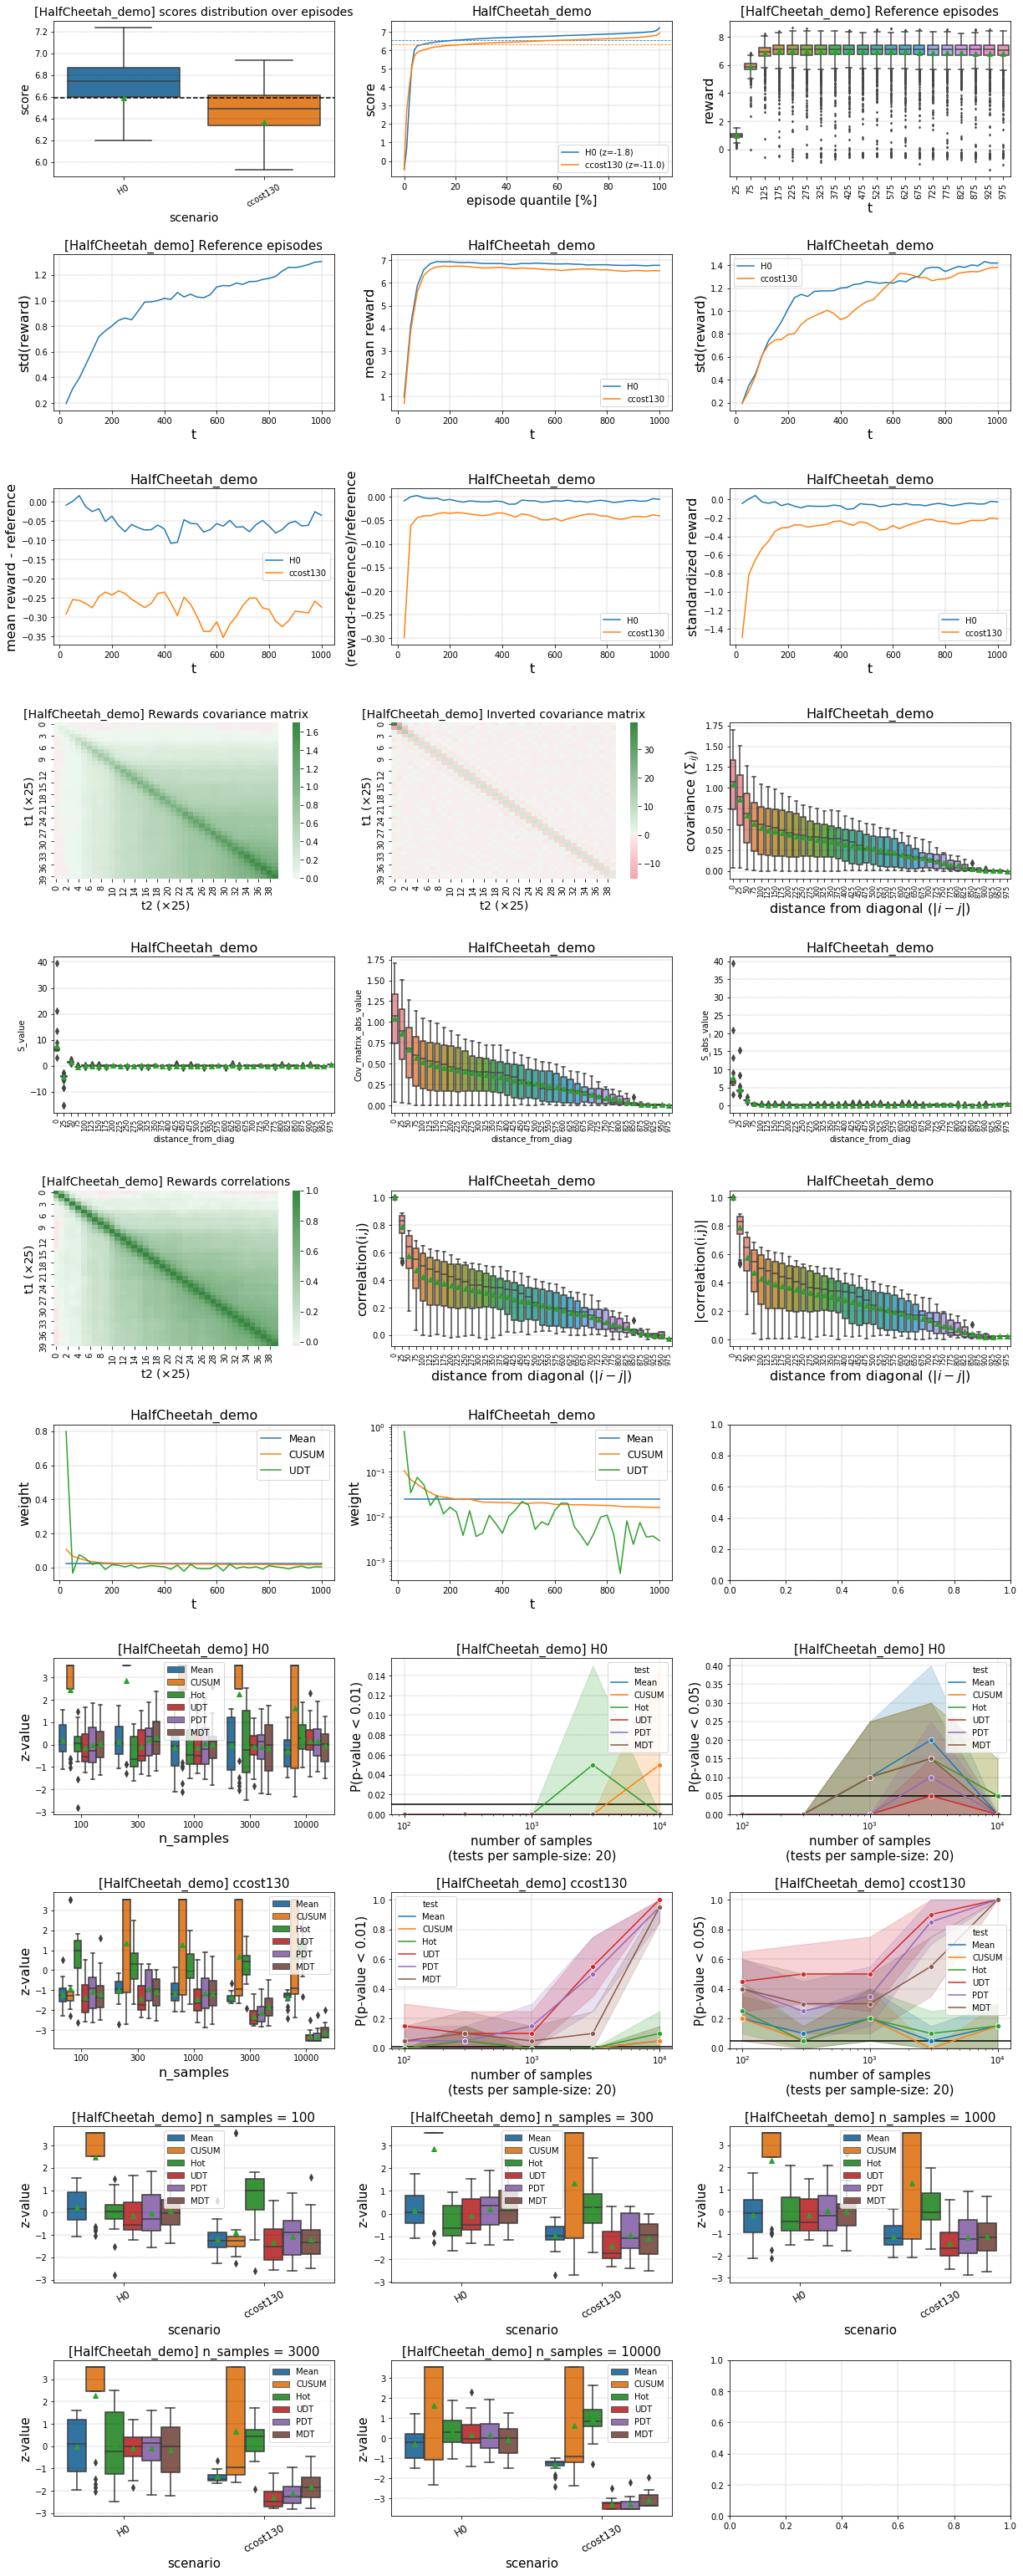

In [71]:
# show analysis
axs = A.analysis_summary('HalfCheetah_demo_individual', do_sequential=False)

**Sequential tests** take longer. Note that this is mostly due to the sequential bootstrap (BFAR from the paper) and the repetitive tests. In particular, the inference time in operational conditions is not expected to be a computational issue.

Scenarios: ['H0', 'ccost130']
Tested scenario: H0
	Mean done.	(2 [s])
	CUSUM done.	(37 [s])
	Hot done.	(41 [s])
	UDT done.	(45 [s])
	PDT done.	(52 [s])
	MDT done.	(108 [s])
Tested scenario: ccost130
	Mean done.	(0 [s])
	CUSUM done.	(1 [s])
	Hot done.	(1 [s])
	UDT done.	(1 [s])
	PDT done.	(2 [s])
	MDT done.	(2 [s])
Non-sequential tests done.	(111 [s])
	001/1000	(37 [s])
	101/1000	(105 [s])
	201/1000	(173 [s])
	301/1000	(250 [s])
	401/1000	(340 [s])
	501/1000	(412 [s])
	601/1000	(485 [s])
	701/1000	(562 [s])
	801/1000	(640 [s])
	901/1000	(718 [s])
	sequential Mean tuned.	(906 [s])
	001/1000	(733 [s])
	101/1000	(843 [s])
	201/1000	(954 [s])
	301/1000	(1067 [s])
	401/1000	(1180 [s])
	501/1000	(1303 [s])
	601/1000	(1433 [s])
	701/1000	(1557 [s])
	801/1000	(1677 [s])
	901/1000	(1800 [s])
	sequential CUSUM tuned.	(2832 [s])
	001/1000	(85 [s])
	101/1000	(202 [s])
	201/1000	(319 [s])
	301/1000	(438 [s])
	401/1000	(557 [s])
	501/1000	(676 [s])
	601/1000	(797 [s])
	701/1000	(919 [s])
	801/1000	(1

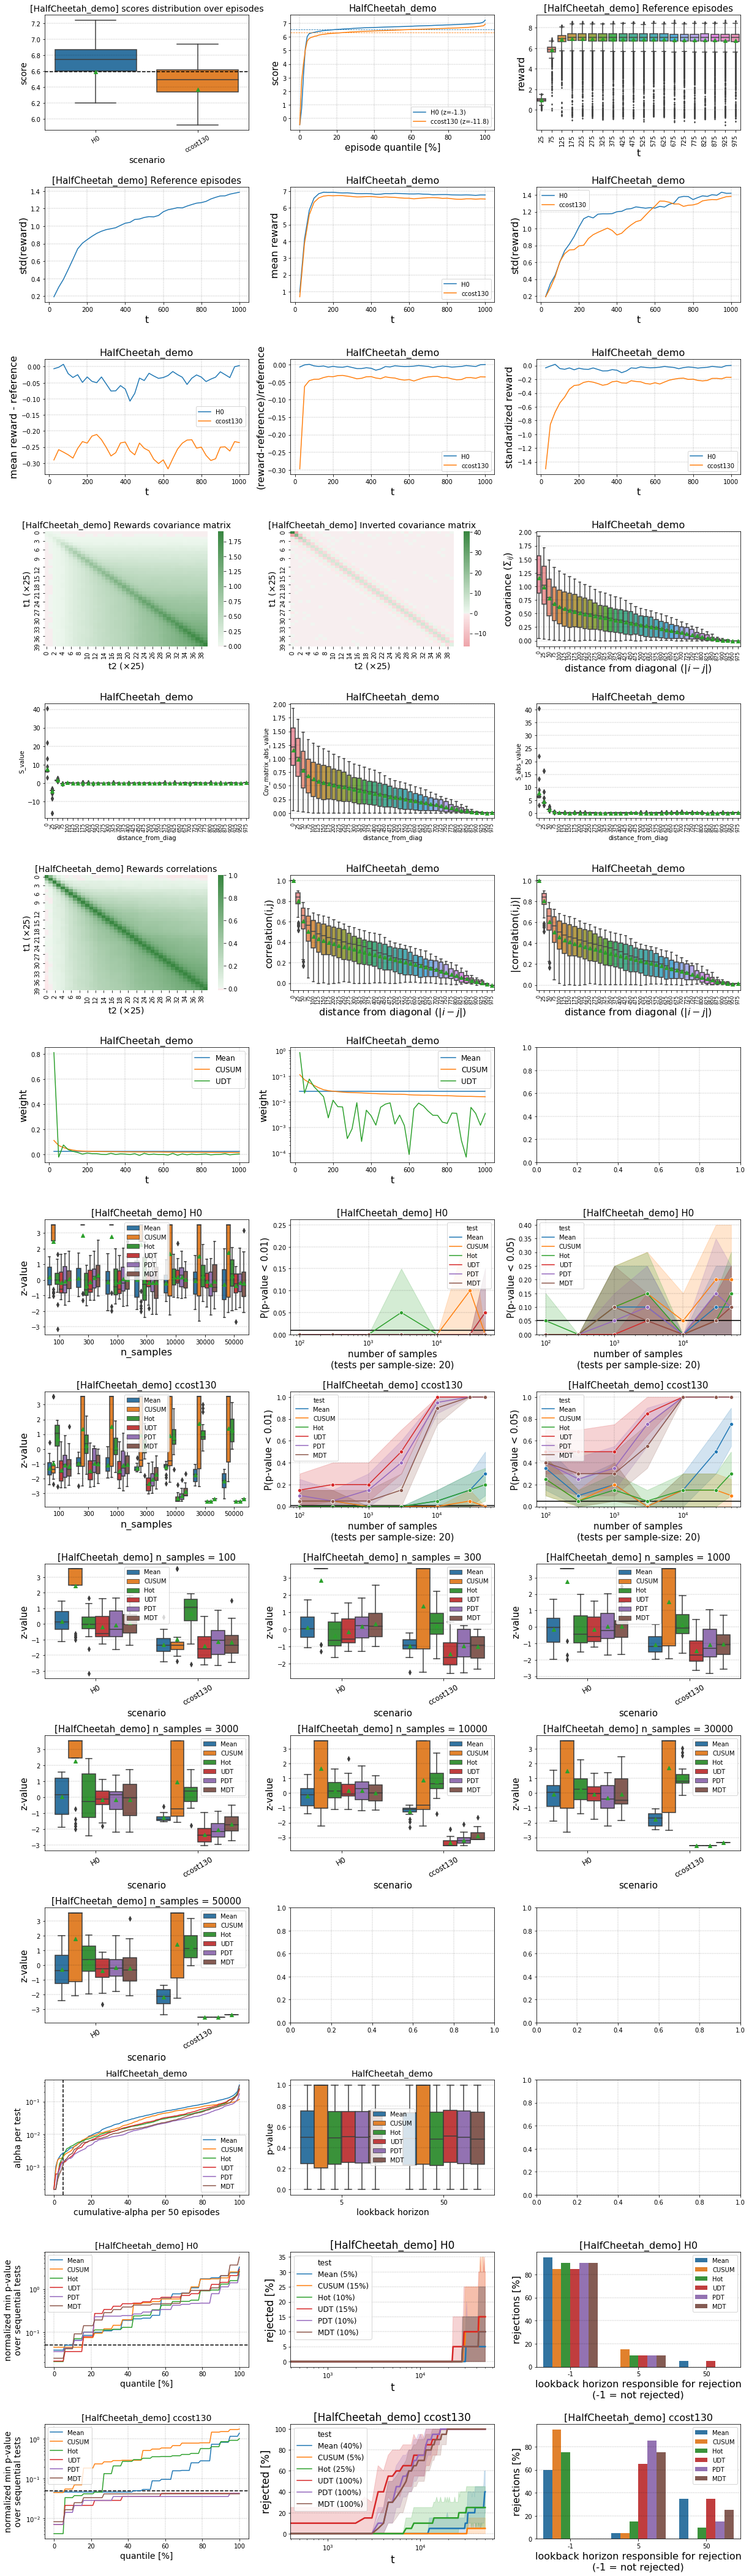

In [35]:
%%time
# run sequential analysis
A.run_summarizing_tests(save_name='HalfCheetah_demo_all', ns=(100,300,1000,3000,10000,30000,50000),
                         default_tester_args=dict(B=5000), lookback_horizons=(5,50), seq_test_len=50, tests=tests)
# show analysis
axs = A.analysis_summary('HalfCheetah_demo_all')

# Analysis of the scenarios from the paper

The rewards data are available upon request.
The tests names are slightly different from the paper: UDWM=UDT, PDM=PDT, Mixed=MDT.

#### Pendulum

In [40]:
P = Analyzer.Analyzer('Pendulum_data_1e7', Path('data'), resolution=10, title='Pendulum')
P.get_meta_scenarios_summary();

meta_scenario
H0          5000 episodes, 100 blocks, 5000 unique seeds.
ccost110    5000 episodes, 100 blocks, 5000 unique seeds.
ccost300    5000 episodes, 100 blocks, 5000 unique seeds.
len090      5000 episodes, 100 blocks, 5000 unique seeds.
len120      5000 episodes, 100 blocks, 5000 unique seeds.
mass090     5000 episodes, 100 blocks, 5000 unique seeds.
mass120     5000 episodes, 100 blocks, 5000 unique seeds.
noise05     5000 episodes, 100 blocks, 5000 unique seeds.
noise10     5000 episodes, 100 blocks, 5000 unique seeds.
noise30     5000 episodes, 100 blocks, 5000 unique seeds.
ref           3000 episodes, 1 blocks, 3000 unique seeds.
dtype: object


Data loaded.	(0 [s])
EDA done.	(3 [s])
Non-sequential tests comparison done.	(63 [s])
Sequential tests comparison done.	(247 [s])


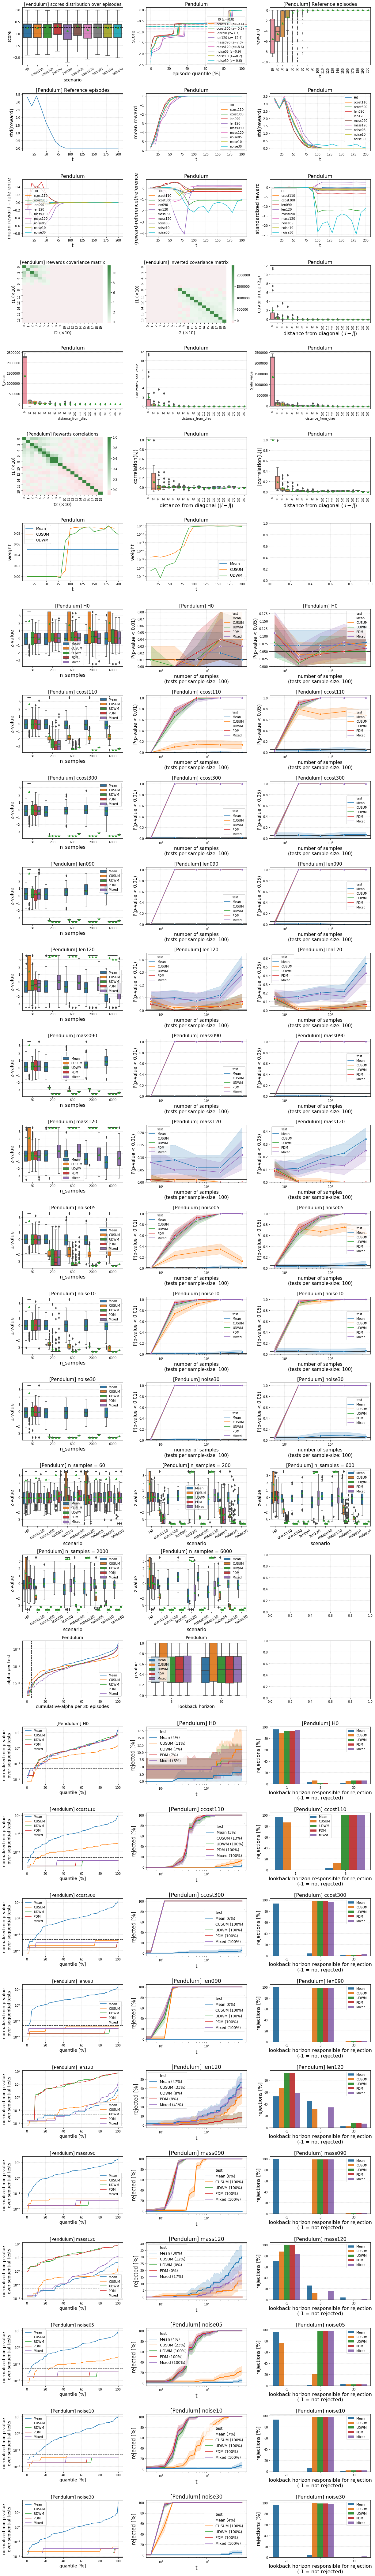

In [41]:
# based on previously-saved results (for a complete example see the analysis demonstration above)
axs = P.analysis_summary(load_file='PendulumAll')

#### HalfCheetah

In [38]:
A = Analyzer.Analyzer('HalfCheetah_data', Path('data'), resolution=25, title='HalfCheetah')
A.rename_scenarios(dict(mass_120='mass120', gravity09='gravity090')) # fix typos in saved names
A.get_meta_scenarios_summary();

meta_scenario
H0            5000 episodes, 100 blocks, 5000 unique seeds.
ccost110      5000 episodes, 100 blocks, 5000 unique seeds.
ccost130      5000 episodes, 100 blocks, 5000 unique seeds.
gravity090    5000 episodes, 100 blocks, 5000 unique seeds.
gravity120    5000 episodes, 100 blocks, 5000 unique seeds.
mass090       5000 episodes, 100 blocks, 5000 unique seeds.
mass120       5000 episodes, 100 blocks, 5000 unique seeds.
ref           10000 episodes, 1 blocks, 10000 unique seeds.
dtype: object


Data loaded.	(0 [s])
EDA done.	(3 [s])
Non-sequential tests comparison done.	(62 [s])
Sequential tests comparison done.	(213 [s])


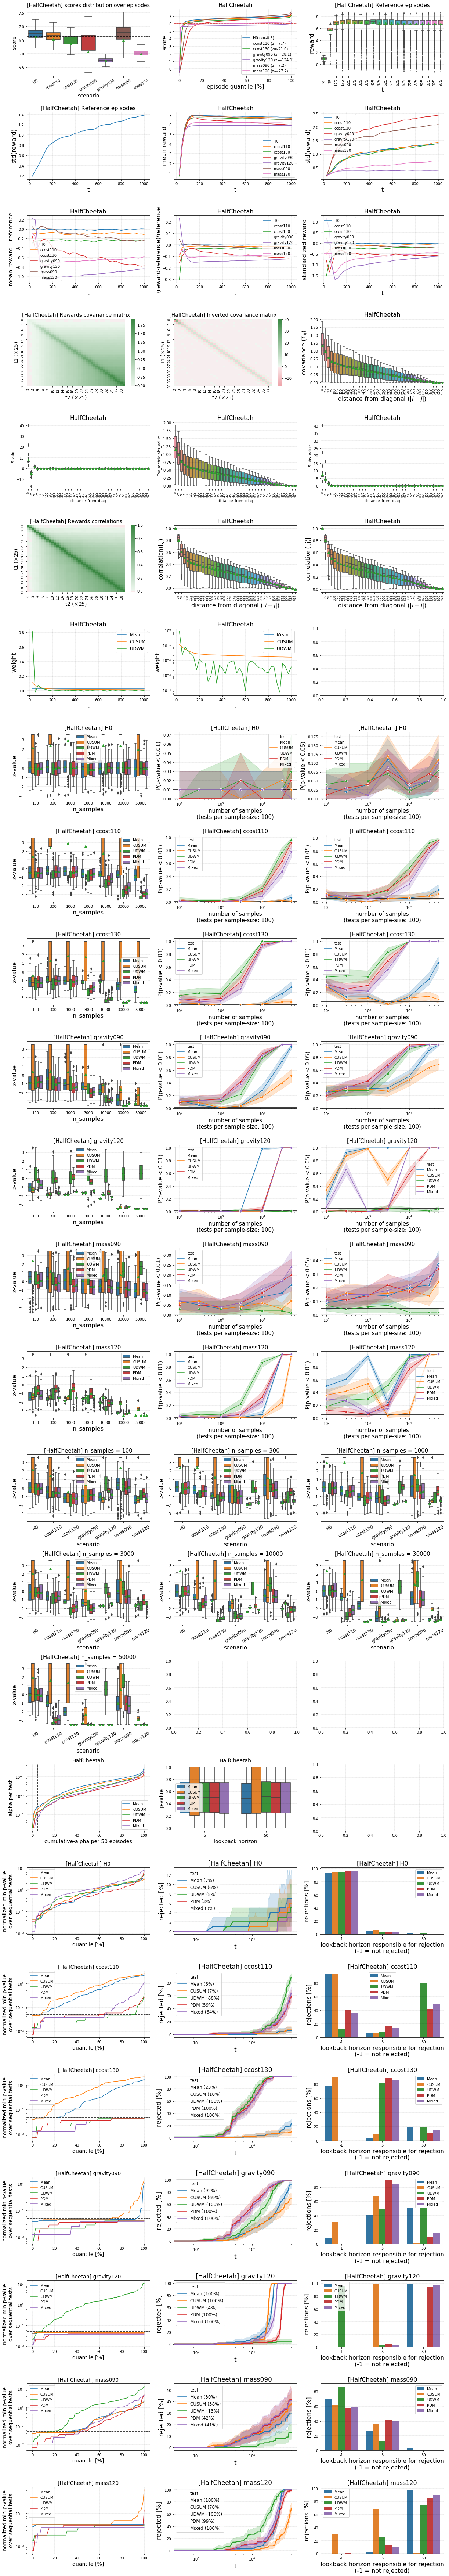

In [39]:
# based on previously-saved results (for a complete example see the analysis demonstration above)
axs = A.analysis_summary(load_file='CheetahAll')

#### Humanoid

In [47]:
# merge two different saved rewards datasets with different scenarios
M = Analyzer.Analyzer('Humanoid_data3', Path('data'), resolution=20, title='Humanoid')
M2 = Analyzer.Analyzer('Humanoid_data', Path('data'), resolution=20, title='Humanoid')
M.merge_analyzer(M2, scenarios2=[s for s in M2.scenarios if 'imcost' not in s])
M.get_meta_scenarios_summary();

meta_scenario
H0          5000 episodes, 100 blocks, 5000 unique seeds.
ccost110    5000 episodes, 100 blocks, 5000 unique seeds.
ccost130    5000 episodes, 100 blocks, 5000 unique seeds.
len090      5000 episodes, 100 blocks, 5000 unique seeds.
len120      5000 episodes, 100 blocks, 5000 unique seeds.
ref           5000 episodes, 1 blocks, 5000 unique seeds.
dtype: object


Data loaded.	(0 [s])
EDA done.	(1 [s])
Non-sequential tests comparison done.	(29 [s])
Sequential tests comparison done.	(126 [s])


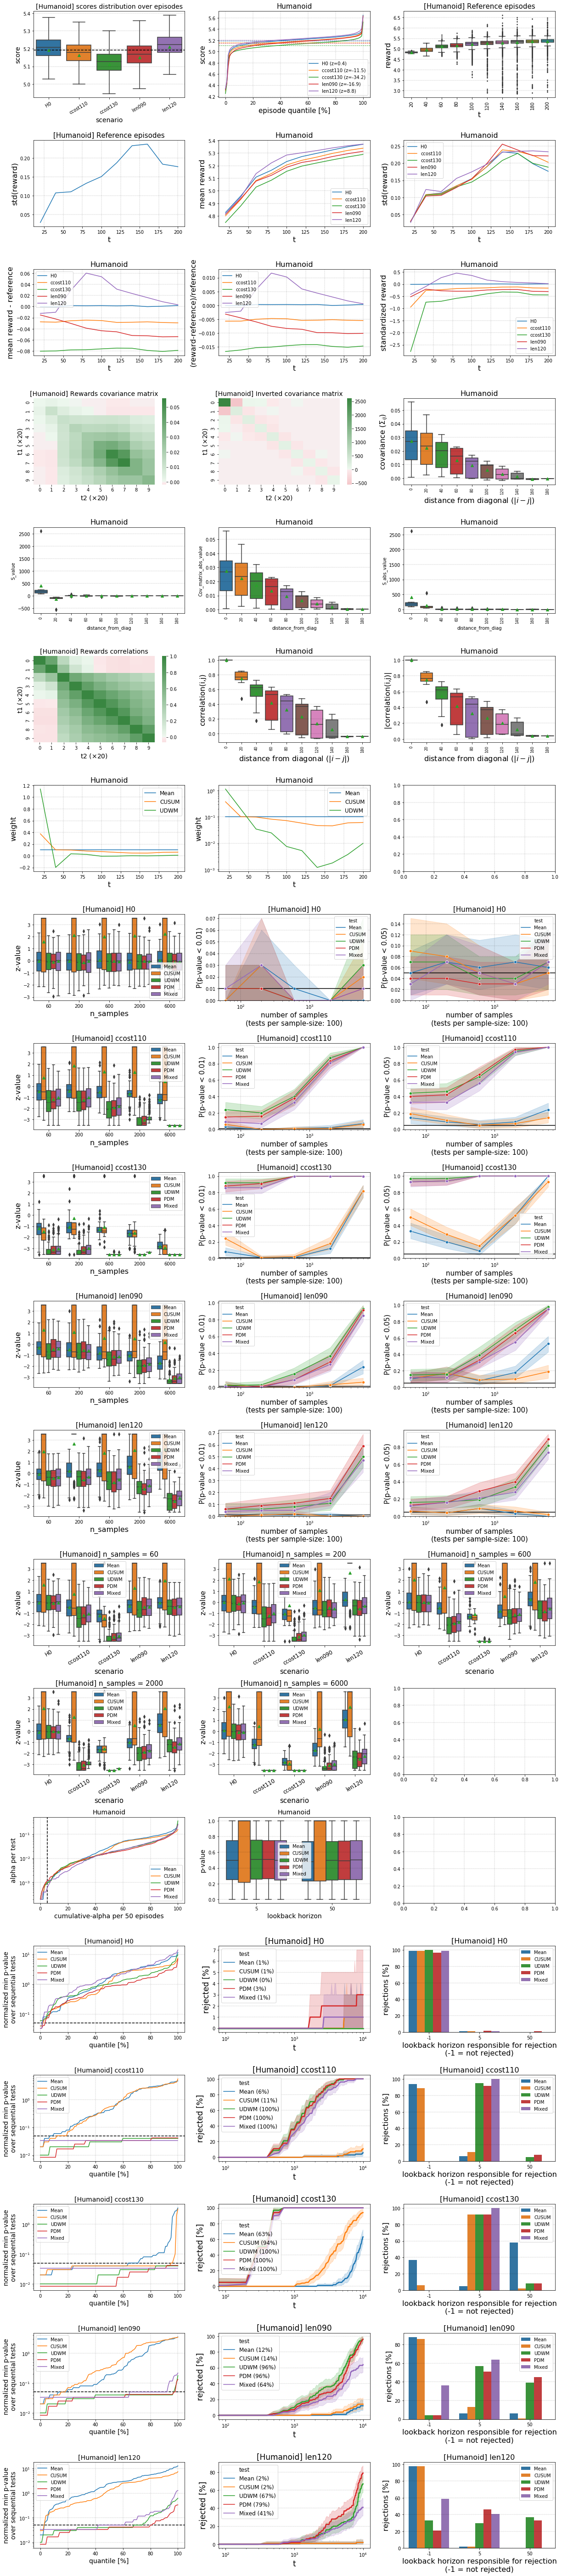

In [48]:
axs = M.analysis_summary(load_file='HumanoidAll')

#### The summarizing mega-figure

In [51]:
rename_dict = dict(UDWM='UDT', PDM='PDT', Mixed='MDT')
rename = lambda k: (rename_dict[k] if k in rename_dict else k)

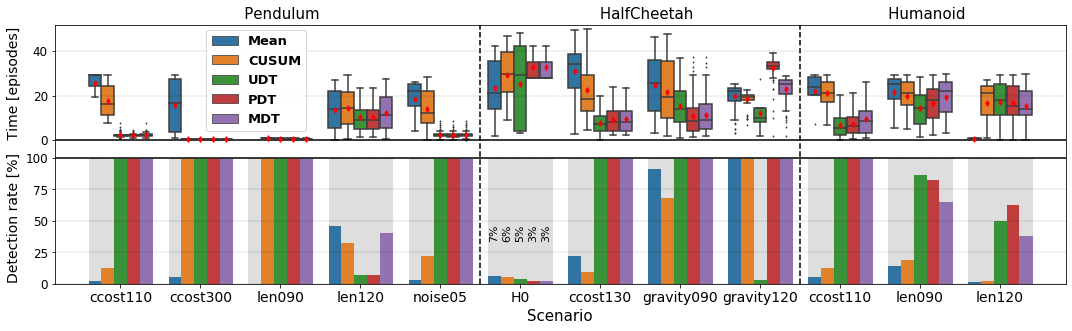

In [53]:
envs = dict(P='PendulumAll', HC='CheetahAll', HUM='HumanoidAll3')
T = dict(P=200, HC=1000, HUM=200)
scenarios_to_plot = dict(
    P = ('ccost110','ccost300','len090','len120','noise05'),
    HC = ('H0','ccost130','gravity090','gravity120'),
    HUM = ('ccost110','len090','len120'),
)
dd = pd.DataFrame()
n_scenarios = []
for nm, fname in envs.items():
    with open(f'outputs/sequential/tests_{fname:s}.pkl', 'rb') as fd:
        d, _ = pkl.load(fd)
    d['env'] = nm
    d['ep_rej'] = d['t_rej'] / T[nm]
    d = d[d.scenario_group.isin(scenarios_to_plot[nm])]
    d['scenario_group'] = [f'[{nm:s}] {sc:s}' for sc in d['scenario_group']]
    n_scenarios.append(len(np.unique(d.scenario_group)))
    dd = pd.concat((dd,d))
dd.reset_index(drop=True, inplace=True)

dd['test'] = [rename(t) for t in dd['test']]
tests = ('Mean', 'CUSUM', 'UDT', 'PDT', 'MDT')
_, ids = np.unique(dd.scenario_group, return_index=True)
all_scenarios = list(dd.scenario_group[np.sort(ids)])

ax = utils.Axes(1,1,axsize=(15,4.7))[0]
for n in np.cumsum(n_scenarios[:-1]):
    ax.axvline(n-0.5, color='k', linestyle='--')
bb = sns.boxplot(data=dd[dd.rej], x='scenario_group', hue='test', y='ep_rej', ax=ax, showmeans=True, fliersize=1, meanprops={"marker":"d","markerfacecolor":"r", "markeredgecolor":'r', "markersize":4},
                hue_order=tests)


plt.draw()
utils.labels(ax, 'Scenario', fontsize=15)
utils.labels(ax, ylab='Detection rate [%]   Time [episodes]', fontsize=14)
utils.labels(ax, title='                   Pendulum                                                           HalfCheetah                                         Humanoid', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=20);
ax.set_yticks([tick for tick in range(0,51,10)]);
ax.set_yticklabels([int(tick) for tick in range(0,51,10)], fontsize=13);

ax.legend(fontsize=13, loc=(0.15,0.59), prop=dict(size=13, weight='bold'))#'best')

dd['sc_test'] = [f'{sc}/{t}' for sc,t in zip(dd.scenario_group,dd.test)]
Hmax = max([ax.get_lines()[1:][len(n_scenarios)-1+7*i].get_ydata()[1] for i in range(len(np.unique(dd[dd.rej].sc_test)))])
Hmin = -1.3*Hmax
ax.set_ylim((Hmin,Hmax+2))#+11))#ax.get_ylim()[1]*1.36))

y1, y2 = ax.get_ylim()
h1, h2 = (Hmin,-8)
ax.axhline(0, color='k')#, linewidth=0.5)
ax.axhline(h2, color='k')#, linewidth=0.5)
ax.axhspan(h2,0, color='w')

time_ticks = [0,20,40]
ax.set_yticks([tick for tick in np.arange(h1,h2+0.1,(h2-h1)/4)] + time_ticks);
ax.set_yticklabels([int(tick) for tick in range(0,101,25)] + time_ticks, fontsize=12);

i = 0
XX = []
YY = []
SS = []
CC = []
for sc in all_scenarios:
    for test in tests:
        CC.append('grey' if 'H0' in sc else 'r')
        d = dd[(dd.scenario_group==sc) & (dd.test==test)]
        l = ax.get_lines()[1:][len(n_scenarios)-1+7*i]
        if d.rej.any():
            XX.append(np.mean(l.get_xdata()))
            YY.append(l.get_ydata()[1])
            i += 1
        else:
            XX.append(np.mean(l.get_xdata())-1/(len(tests)+1))
            YY.append(0)
        pos = (XX[-1], YY[-1])
        scores = [100 * dd[(dd.scenario_group==sc) & (dd.test==tst)].rej.astype(int).mean() for tst in tests]
        score = 100 * d.rej.astype(int).mean()
        SS.append(100-score)
        max_score = max(scores)
        min_score = min(scores)
        rel_score = (score-min_score)/(max_score-min_score)
        if 'H0' in sc:
            ax.annotate(f'{score:.0f}%', (pos[0],(h1+h2)/2-6), ha='center', va='top', fontsize=11, textcoords='offset points',
                        color='k', rotation=90, xytext=(0,10) # p.get_facecolor()
                       )

colors = [a.get_facecolor() for a in bb.artists[:len(tests)]]
fit_in = lambda yy: (yy-y1) / (y2-y1)
margin = 0
for i,(xx,ss,cc) in enumerate(zip(XX,SS,CC)):
    yy = h1 + margin/2 + (h2-h1-margin) * (1 - ss/100)
    ax.axvspan(xx-1/(len(tests)+1.5)/2, xx+1/(len(tests)+1.5)/2, ymin=fit_in(h1), ymax=fit_in(yy-margin/2), alpha=1, color=colors[i%len(colors)])
    ax.axvspan(xx-1/(len(tests)+1.5)/2, xx+1/(len(tests)+1.5)/2, ymin=fit_in(yy+margin/2), ymax=fit_in(h2), alpha=1, color=[0.87,0.87,0.87,1])

plt.draw()
ax.set_xticklabels([str(s)[str(s).find(']')+2:-2] for s in ax.get_xticklabels()], rotation=0)

plt.tight_layout();